In [1]:
# Bagian 1: import Library yang Diperlukan

import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow / Keras (Untuk Skema 2 & 3)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SpatialDropout1D, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Transformers (Untuk Skema 3)
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

# Visualisasi (Opsional)
import seaborn as sns
import matplotlib.pyplot as plt

print("Semua library berhasil di-load.")

c:\miniconda\envs\gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Semua library berhasil di-load.


In [2]:
# Bagian 2: Muat dan Labeli Data

# Muat dataset mentah
df = pd.read_csv('dataset_mentah.csv')
print(f"Jumlah data awal: {len(df)}")

# Menghapus data duplikat dan null
df = df.dropna(subset=['text'])
df = df.drop_duplicates(subset=['text'])
print(f"Jumlah data setelah hapus null/duplikat: {len(df)}")

# 2. Pelabelan 3 kelas sentimen
def apply_sentiment_label(score):
    if score <= 2:
        return 'negatif'
    elif score == 3:
        return 'netral'
    elif score >= 4:
        return 'positif'

df['sentiment'] = df['score'].apply(apply_sentiment_label)

# Cek distribusi data
print("\nDistribusi data per kelas:")
print(df['sentiment'].value_counts()) 

# Menyimpan kolom yang diperlukan
df_clean = df[['text', 'sentiment']]

Jumlah data awal: 11000
Jumlah data setelah hapus null/duplikat: 8385

Distribusi data per kelas:
sentiment
positif    6467
negatif    1587
netral      331
Name: count, dtype: int64


In [3]:
# Bagian 3: Text Preprocessing

# Download NLTK stopwords
nltk.download('stopwords')
list_stopwords = stopwords.words('indonesian')

# Setup Sastrawi Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# kamus slang
slang_dict = {
    # A
    'ad': 'ada', 'adlh': 'adalah', 'afaik': 'as far as I know', 'ajah': 'saja', 'aj': 'saja',
    'aja': 'saja', 'ak': 'aku', 'aq': 'aku', 'akoh': 'aku', 'akkoh': 'aku', 'ako': 'aku',
    'alay': 'norak', 'ambyar': 'hancur', 'ansos': 'anti sosial', 'ap2': 'apa-apa',
    'apaan': 'apa', 'apasi': 'apa sih', 'apes': 'sial', 'ato': 'atau', 'auto': 'otomatis',
    'apk': 'aplikasi',
    # B
    'bacot': 'banyak bicara', 'baper': 'bawa perasaan', 'bagai': 'seperti', 'baget': 'banget',
    'bahi': 'bagi', 'bais': 'habis', 'banget': 'sekali', 'bangke': 'bangsat', 'bansat': 'bangsat',
    'based': 'berdasar', 'bbrp': 'beberapa', 'bcanda': 'bercanda', 'bdg': 'bandung',
    'beb': 'sayang', 'bejibun': 'banyak', 'bencong': 'waria', 'bener': 'benar',
    'beneran': 'sungguh', 'bestie': 'sahabat', 'bgt': 'banget', 'bgs': 'bagus',
    'bgst': 'bangsat', 'bkn': 'bukan', 'bl': 'beli', 'blg': 'bilang', 'blm': 'belum',
    'bngt': 'banget', 'bnr': 'benar', 'bnyk': 'banyak', 'bokap': 'ayah', 'boker': 'buang air besar',
    'bokek': 'tidak punya uang', 'bole': 'boleh', 'br': 'baru', 'brg': 'barang',
    'brp': 'berapa', 'bro': 'teman', 'brur': 'teman', 'bs': 'bisa', 'bsk': 'besok',
    'bt': 'buat', 'btw': 'ngomong-ngomong', 'bucin': 'budak cinta', 'bused': 'buset',
    'buay': 'untuk', 'bw': 'bawa', 'bwt': 'buat',
    # C
    'cabs': 'cabut', 'canda': 'bercanda', 'cape': 'capai', 'caur': 'hancur',
    'cegil': 'cewek gila', 'cepet': 'cepat', 'cmiiw': 'correct me if I am wrong',
    'cmpur': 'campur', 'cong': 'kawan', 'cowil': 'cowok gila', 'cringe': 'menjijikkan',
    'crta': 'cerita', 'cuek': 'tidak peduli', 'cuy': 'kawan',
    # D
    'd': 'di', 'damage': 'mempesona', 'dgn': 'dengan', 'dg': 'dengan', 'dh': 'sudah',
    'dl': 'dulu', 'dlu': 'dulu', 'dmn': 'di mana', 'dms': 'di mana', 'dng': 'dengan',
    'doi': 'pacar', 'dong': 'tolong', 'dpt': 'dapat', 'dr': 'dari', 'dri': 'dari',
    'drmn': 'dari mana', 'drpd': 'daripada', 'dtg': 'datang', 'duren': 'durian',
    # E
    'edun': 'gila', 'elu': 'kamu', 'emg': 'memang', 'emng': 'memang', 'engga': 'tidak',
    'enggak': 'tidak', 'entah': 'tidak tahu', 'envy': 'iri',
    # F
    'faedah': 'manfaat', 'fak': 'kata umpatan', 'flexing': 'pamer', 'fyi': 'sebagai informasi',
    # G
    'ga': 'tidak', 'gabut': 'bosan', 'gaje': 'tidak jelas', 'gak': 'tidak',
    'gan': 'juragan', 'garing': 'tidak lucu', 'gas': 'ayo', 'gaskeun': 'ayo',
    'gawe': 'kerja', 'gebetan': 'orang yang disukai', 'gemoy': 'gemas', 'ghoib': 'gaib',
    'ghosting': 'menghilang tiba-tiba', 'gils': 'gila', 'gitu': 'begitu', 'gmn': 'bagaimana',
    'gokil': 'gila', 'gpp': 'tidak apa-apa', 'gra': 'gara-gara', 'gretong': 'gratis',
    'gue': 'saya', 'gua': 'saya', 'gw': 'saya',
    # H
    'ha': 'tertawa', 'haha': 'tertawa', 'hancur': 'rusak', 'healing': 'liburan',
    'helo': 'halo', 'hoax': 'berita palsu', 'hqq': 'hakiki', 'hrs': 'harus',
    'hub': 'hubungan', 'human': 'manusia',
    # I
    'ilang': 'hilang', 'ilfil': 'tidak suka', 'imo': 'in my opinion', 'iri': 'dengki',
    'iy': 'iya',
    # J
    'j': 'juga', 'ja': 'saja', 'jd': 'jadi', 'jdi': 'jadi', 'jgn': 'jangan',
    'jg': 'juga', 'jga': 'juga', 'jijay': 'jijik', 'jln': 'jalan', 'jomblo': 'lajang',
    'julid': 'nyinyir', 'just': 'hanya',
    # K
    'k': 'ke', 'kabor': 'kabur', 'kaka': 'kakak', 'kalo': 'kalau', 'kamseupay': 'norak',
    'karna': 'karena', 'kayak': 'seperti', 'kbr': 'kabar', 'kcil': 'kecil', 'kdg': 'kadang',
    'kece': 'keren', 'kekeuh': 'keras kepala', 'kepo': 'penasaran', 'kere': 'miskin',
    'kids': 'anak-anak', 'kl': 'kalau', 'klo': 'kalau', 'klu': 'kalau', 'km': 'kamu',
    'kmpus': 'kampus', 'kmrn': 'kemarin', 'kn': 'kan', 'knp': 'kenapa', 'knpa': 'kenapa',
    'komuk': 'muka', 'konci': 'kunci', 'kr': 'kurang', 'krg': 'kurang', 'krn': 'karena',
    'krna': 'karena', 'krm': 'kirim', 'kt': 'kita', 'kta': 'kita', 'ktmu': 'ketemu',
    'ktr': 'kantor', 'kuy': 'ayo', 'ky': 'seperti', 'kyk': 'seperti', 'kyknya': 'sepertinya',
    # L
    'l': 'kamu', 'la': 'lah', 'lbh': 'lebih', 'lebay': 'berlebihan', 'lemot': 'lambat',
    'lg': 'lagi', 'lgsg': 'langsung', 'lht': 'lihat', 'lmyan': 'lumayan', 'loe': 'kamu',
    'lo': 'kamu', 'low': 'rendah', 'lp': 'lupa', 'lupa': 'lalai', 'lw': 'kamu',
    # M
    'maaci': 'terima kasih', 'mager': 'malas gerak', 'males': 'malas', 'makin': 'semakin',
    'malah': 'justru', 'mantul': 'mantap betul', 'masi': 'masih', 'mending': 'lebih baik',
    'mepet': 'terdesak', 'mks': 'terima kasih', 'mksh': 'terima kasih', 'mlh': 'malah',
    'mls': 'malas', 'mnt': 'minta', 'moga': 'semoga', 'mrk': 'mereka', 'msg': 'masing',
    'mslh': 'masalah', 'mst': 'mesti',
    # N
    'n': 'dan', 'nanya': 'bertanya', 'napa': 'kenapa', 'napsu': 'nafsu', 'nax': 'anak',
    'ndak': 'tidak', 'ngab': 'bang', 'ngakak': 'tertawa keras', 'ngapain': 'sedang apa',
    'ngaret': 'terlambat', 'ngasih': 'memberi', 'ngegas': 'marah', 'ngga': 'tidak',
    'nggk': 'tidak', 'ngmg': 'bicara', 'ngomong': 'bicara', 'nt': 'nice try', 'ntar': 'nanti',
    'ntn': 'nonton', 'numb': 'mati rasa', 'nyesek': 'sesak', 'nyokap': 'ibu',
    # O
    'o': 'oleh', 'ogah': 'tidak mau', 'oke': 'setuju', 'ok': 'setuju', 'otw': 'sedang di jalan',
    # P
    'p': 'pergi', 'pansos': 'panjat sosial', 'paripurna': 'sempurna', 'pd': 'pada',
    'pdhl': 'padahal', 'peka': 'sensitif', 'pelakor': 'perebut laki orang',
    'pencitraan': 'pura-pura baik', 'pengen': 'ingin', 'peres': 'bohong', 'pgn': 'ingin',
    'php': 'pemberi harapan palsu', 'plg': 'paling', 'pls': 'tolong', 'plz': 'tolong',
    'pm': 'private message', 'pms': 'sedang datang bulan', 'prg': 'pergi', 'pw': 'posisi',
    # Q-R
    'qt': 'kita', 'qta': 'kita', 'r': 'kamu', 'receh': 'murahan', 'relate': 'terhubung',
    'rempong': 'repot', 'riweuh': 'repot', 'rmh': 'rumah',
    # S
    'sabi': 'bisa', 'salfok': 'salah fokus', 'salt': 'kesal', 'salty': 'kesal',
    'sampe': 'sampai', 'sans': 'santai', 'santuy': 'santai', 'savage': 'sadis',
    'sbg': 'sebagai', 'sbgi': 'sebagai',
    # U-Y
    'udh': 'sudah', 'utk': 'untuk', 'yg': 'yang', 'yuk': 'ayo', 'y': 'ya'
}
slang_dict_keys = slang_dict.keys()

def preprocess_text(text):
    # 1. Case folding
    text = text.lower()
    
    # 2. Hapus URL, mention, hashtag, angka
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    
    # 3. Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 4. Normalisasi Slang
    words = text.split()
    normalized_words = [slang_dict[word] if word in slang_dict_keys else word for word in words]
    text = ' '.join(normalized_words)
    
    # 5. Hapus Stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in list_stopwords]
    text = ' '.join(filtered_words)
    
    # 6. Stemming (Proses ini bisa memakan waktu lama)
    text = stemmer.stem(text) 
    
    # 7. Hapus whitespace berlebih
    text = text.strip()
    
    return text

# Terapkan preprocessing ke kolom 'text'
print("Memulai preprocessing teks...")
df_clean['text_clean'] = df_clean['text'].apply(preprocess_text)
print("Preprocessing selesai.")

# Hapus data yang teksnya jadi kosong setelah preprocessing
df_clean = df_clean[df_clean['text_clean'] != '']

# Simpan dataset bersih 
df_clean.to_csv('dataset_final.csv', index=False)

print("\nContoh data setelah preprocessing:")
print(df_clean[['text', 'text_clean', 'sentiment']].head())

[nltk_data] Downloading package stopwords to C:\Users\TUFF
[nltk_data]     GAMING\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Memulai preprocessing teks...


C:\Users\TUFF GAMING\AppData\Local\Temp\ipykernel_24680\336055541.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['text_clean'] = df_clean['text'].apply(preprocess_text)


Preprocessing selesai.

Contoh data setelah preprocessing:
                                                text  \
0  sudah aplikasi lemot, pertama buka langsung di...   
1                          banyak diskon voucher nya   
2                      makin lambat pengiriman males   
4                                           nice apk   
5                                          memuaskan   

                                text_clean sentiment  
0  aplikasi lambat buka langsung arah live   negatif  
1                       diskon voucher nya   positif  
2                       lambat kirim malas   negatif  
4                            nice aplikasi   positif  
5                                     muas   positif  


In [4]:
# Bagian 4: Persiapan Data untuk Model 

# Muat data bersih (jika notebook di-restart)
df_clean = pd.read_csv('dataset_final.csv').dropna() # Menghapus null jika ada

# 1. Pisahkan Fitur (X) dan Target (y)
X = df_clean['text_clean']
y = df_clean['sentiment']

# 2. Encode Label (y)
# (negatif: 0, netral: 1, positif: 2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\nLabel dan Encodenya: {list(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# 3. Pembagian Data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"\nUkuran data train: {X_train.shape[0]}")
print(f"Ukuran data test: {X_test.shape[0]}")

def show_evaluation(X_test, y_test, model, model_name="Model"):
    # Prediksi
    y_pred = model.predict(X_test)
    
    # Jika output model DL (softmax), perlu argmax
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)
        
    # Hitung akurasi
    accuracy = accuracy_score(y_test, y_pred)
    print(f"--- {model_name} Evaluation ---")
    print(f"Akurasi Test: {accuracy * 100:.2f}%")
    
    # Menampilkan Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Menampilkan Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return accuracy


Label dan Encodenya: [('negatif', 0), ('netral', 1), ('positif', 2)]

Ukuran data train: 6603
Ukuran data test: 1651



Memulai Pelatihan Skema 1: TF-IDF + SVM
Pelatihan Skema 1 Selesai.
--- Skema 1: SVM Evaluation ---
Akurasi Test: 86.80%

Classification Report:
              precision    recall  f1-score   support

     negatif       0.72      0.68      0.70       315
      netral       0.33      0.02      0.03        64
     positif       0.90      0.96      0.93      1272

    accuracy                           0.87      1651
   macro avg       0.65      0.55      0.55      1651
weighted avg       0.85      0.87      0.85      1651



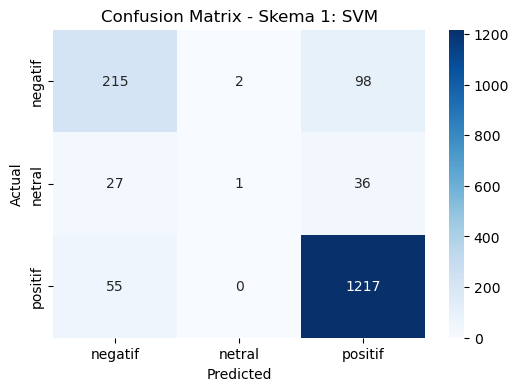

Akurasi Training SVM: 92.99%


In [5]:
# Bagian 5: Skema 1 (TF-IDF + SVM) 

print("\nMemulai Pelatihan Skema 1: TF-IDF + SVM")

# Buat pipeline
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear', C=1.0, random_state=42)) # Kernel linear seringkali bagus untuk teks
])

# Latih model
pipeline_svm.fit(X_train, y_train)

print("Pelatihan Skema 1 Selesai.")

# Evaluasi model
acc_svm = show_evaluation(X_test, y_test, pipeline_svm, "Skema 1: SVM")

# Cek akurasi training (untuk melihat overfitting)
y_train_pred_svm = pipeline_svm.predict(X_train)
acc_train_svm = accuracy_score(y_train, y_train_pred_svm)
print(f"Akurasi Training SVM: {acc_train_svm * 100:.2f}%")


Memulai Pelatihan Skema 2: Embedding + LSTM
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 100, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,329,603
Trainable params: 1,329,603
Non-trainable params: 0

c:\miniconda\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\miniconda\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\miniconda\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


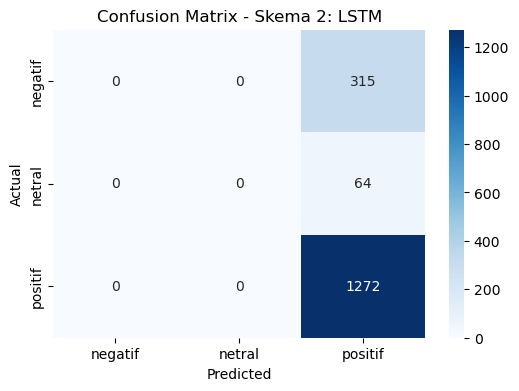

Akurasi Training LSTM: 77.03%
Akurasi Testing LSTM: 77.04%


In [10]:
# Bagian 6: Skema 2 (Embedding + LSTM) 

print("\nMemulai Pelatihan Skema 2: Embedding + LSTM")

# 1. Tokenisasi Teks
VOCAB_SIZE = 10000  # Ambil 10.000 kata paling umum
MAX_LEN = 100       # Potong/padding kalimat jadi 100 kata
EMBEDDING_DIM = 128 # Dimensi vektor embedding

tokenizer_lstm = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_lstm.fit_on_texts(X_train)

# Konversi teks ke sequence
X_train_seq = tokenizer_lstm.texts_to_sequences(X_train)
X_test_seq = tokenizer_lstm.texts_to_sequences(X_test)

# Padding sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# 2. One-hot encode label (untuk loss 'categorical_crossentropy')
NUM_CLASSES = 3
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

# 3. Buat Arsitektur Model LSTM
model_lstm = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    SpatialDropout1D(0.2), # Dropout khusus untuk data sekuensial
    LSTM(64, dropout=0.3, recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()

# 4. Pelatihan Model
BATCH_SIZE = 64
EPOCHS = 10
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
]

history_lstm = model_lstm.fit(
    X_train_pad, y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

print("Pelatihan Skema 2 Selesai.")

# 5. Evaluasi Model
acc_lstm = show_evaluation(X_test_pad, y_test, model_lstm, "Skema 2: LSTM")

# Cek akurasi training
train_loss, train_acc_lstm = model_lstm.evaluate(X_train_pad, y_train_cat, verbose=0)
print(f"Akurasi Training LSTM: {train_acc_lstm * 100:.2f}%")
print(f"Akurasi Testing LSTM: {acc_lstm * 100:.2f}%")


Memulai Pelatihan Skema 3: Embedding + 1D-CNN
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 dropout_6 (Dropout)         (None, 100, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
       

c:\miniconda\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\miniconda\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\miniconda\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


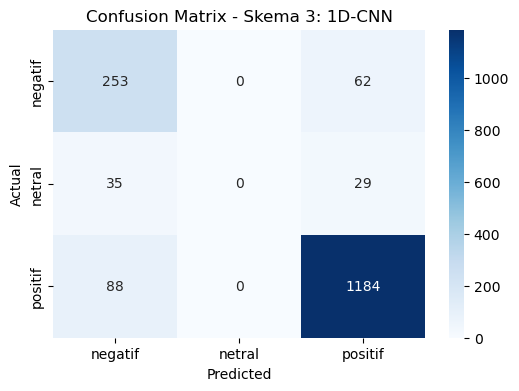

Akurasi Training 1D-CNN: 90.70%
Akurasi Testing 1D-CNN: 87.04%


In [12]:
# --- Bagian 7: Skema 3 (1D-CNN) ---

print("\nMemulai Pelatihan Skema 3: Embedding + 1D-CNN")


model_cnn = Sequential([
    # 1. Embedding Layer
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Dropout(0.3), # Mencegah overfitting
    
    # 2. Convolutional Layer
    # 'filters=128': Mencari 128 pola frasa yang berbeda
    # 'kernel_size=5': Melihat 5 kata sekaligus (frasa 5 kata)
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    
    # 3. Pooling Layer (Ambil yang terpenting)
    GlobalMaxPooling1D(),
    
    # 4. Fully Connected Layer
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    # 5. Output Layer
    Dense(NUM_CLASSES, activation='softmax')
])

model_cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_cnn.summary()

history_cnn = model_cnn.fit(
    X_train_pad, y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=callbacks, # Kita pakai callback EarlyStopping yang sama
    verbose=1
)

print("Pelatihan Skema 3 (1D-CNN) Selesai.")

# 3. Evaluasi Model
acc_cnn = show_evaluation(X_test_pad, y_test, model_cnn, "Skema 3: 1D-CNN")

# Cek akurasi training
train_loss, train_acc_cnn = model_cnn.evaluate(X_train_pad, y_train_cat, verbose=0)
print(f"Akurasi Training 1D-CNN: {train_acc_cnn * 100:.2f}%")
print(f"Akurasi Testing 1D-CNN: {acc_cnn * 100:.2f}%")

In [ ]:
# SIMPAN MODEL & TOKENIZER 
import pickle

# 1. Simpan model Keras 1D-CNN
model_cnn.save('model_cnn_terbaik.h5')
print("Model 1D-CNN berhasil disimpan ke 'model_cnn_terbaik.h5'")

# 2. Simpan tokenizer 
with open('tokenizer_cnn.pickle', 'wb') as handle:
    pickle.dump(tokenizer_lstm, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer berhasil disimpan ke 'tokenizer_cnn.pickle'")

Model 1D-CNN berhasil disimpan ke 'model_cnn_terbaik.h5'
Tokenizer berhasil disimpan ke 'tokenizer_cnn.pickle'


In [ ]:
# Bagian 8: Inferensi 

print("\nMemulai Uji Coba Inferensi (Model 1D-CNN)...")

# Import library yang dibutuhkan untuk inferensi
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -------------------------------------------------------------------
# Definisikan ulang parameter
MAX_LEN = 100 
# -------------------------------------------------------------------

try:
    # 1. Muat model Keras yang sudah disimpan
    loaded_model = load_model('model_cnn_terbaik.h5')
    
    # 2. Muat tokenizer yang sudah disimpan
    with open('tokenizer_cnn.pickle', 'rb') as handle:
        loaded_tokenizer = pickle.load(handle)
        
    print("Model 1D-CNN dan Tokenizer berhasil di-load.")

    # Definisikan ulang label (pastikan label_encoder sudah ada dari cell sebelumnya)
    labels = label_encoder.classes_ # ['negatif', 'netral', 'positif']

    def predict_sentiment_cnn(text_input):
        # 1. Preprocessing teks input (SAMA PERSIS dengan training)
        processed_text = preprocess_text(text_input)
        
        # 2. Tokenisasi (ubah teks jadi angka)
        sequence = loaded_tokenizer.texts_to_sequences([processed_text])
        
        # 3. Padding 
        padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')
        
        # 4. Prediksi
        prediction = loaded_model.predict(padded_sequence)
        
        # 5. Dapatkan kelas prediksi berdasar index dgn probabilitas tertinggi
        predicted_class_id = np.argmax(prediction, axis=1)[0]
        
        # 6. Kembalikan label
        return labels[predicted_class_id]

    # --- BUKTI INFERENSI ---
    print("\n--- [Output Bukti Inferensi] ---")
    
    teks_1 = "Aplikasinya bagus banget, lancar jaya dan fiturnya lengkap!"
    print(f"Teks: '{teks_1}'")
    print(f"Prediksi Sentimen: {predict_sentiment_cnn(teks_1)}")
    print("-" * 30)

    teks_2 = "Update terbaru ini kok malah bikin error terus ya? Gak bisa dibuka. Tolong perbaiki."
    print(f"Teks: '{teks_2}'")
    print(f"Prediksi Sentimen: {predict_sentiment_cnn(teks_2)}")
    print("-" * 30)

    teks_3 = "Biasa aja sih, fiturnya standar. Gak ada yang spesial tapi oke lah."
    print(f"Teks: '{teks_3}'")
    print(f"Prediksi Sentimen: {predict_sentiment_cnn(teks_3)}")
    print("-" * 30)
    
    teks_4 = "parah abis lemot bgt apk nya"
    print(f"Teks: '{teks_4}'")
    print(f"Prediksi Sentimen: {predict_sentiment_cnn(teks_4)}")
    print("-" * 30)
    
    print("--- [Akhir Bukti Inferensi] ---")

except Exception as e:
    print(f"\nGagal melakukan inferensi. Pastikan Anda sudah menyimpan model dan tokenizer. Error: {e}")


Memulai Uji Coba Inferensi (Model 1D-CNN)...
Model 1D-CNN dan Tokenizer berhasil di-load.

--- [Output Bukti Inferensi] ---
Teks: 'Aplikasinya bagus banget, lancar jaya dan fiturnya lengkap!'
1/1 [==============================] - 0s 117ms/step
Prediksi Sentimen: positif
------------------------------
Teks: 'Update terbaru ini kok malah bikin error terus ya? Gak bisa dibuka. Tolong perbaiki.'
1/1 [==============================] - 0s 30ms/step
Prediksi Sentimen: negatif
------------------------------
Teks: 'Biasa aja sih, fiturnya standar. Gak ada yang spesial tapi oke lah.'
1/1 [==============================] - 0s 28ms/step
Prediksi Sentimen: positif
------------------------------
Teks: 'parah abis lemot bgt apk nya'
1/1 [==============================] - 0s 29ms/step
Prediksi Sentimen: negatif
------------------------------
--- [Akhir Bukti Inferensi] ---
